## In this mini project I am trying to built my own Random Forest from scratch and visualize how trees work together to improve accuracy and reduce overfitting.

# Step 1 : Creating a  dummy data and Implementing Bootstrap Sampling and Random Feature Selection Together 

- Why Boostrap Sampling ? 

Because I want to give random data samples to each of my models so that each model will predict different patterns 

- Why Random Feature Selection ?

I want each tree to pick some features randomly instead of picking all features. So if one tree misses to find a pattern the other tree might find it. 

In [75]:

import numpy as np
import pandas as pd 

# Creating the data  

np.random.seed(33)
data=pd.DataFrame({'feature1':np.random.randint(0,10,10),'feature2':np.random.randint(0,10,10),'feature3':
                  np.random.randint(0,10,10),'label':np.random.choice([0,1],10)})

# np.random.randint(low,high,size) will create a 1D array starting from low upto high-1
# np.random.choice generates a random sample from a given 1D array. Pick 10 random values from list [0,1]

In [76]:
print(data)

   feature1  feature2  feature3  label
0         4         3         8      0
1         7         1         8      1
2         8         7         3      0
3         2         6         7      1
4         2         0         9      1
5         9         0         3      1
6         9         6         3      0
7         3         6         7      1
8         6         0         3      0
9         3         4         7      0


### Writing a function which will perform Bootstrap sampling (With Replacement ---> Duplicates can exist)

In [77]:
def bootstrap_sampling(data):
    # First I figure out how many rows the data has 
    number_of_rows=data.shape[0]  # df.shape[0/1] will return the number of rows(if 0) or the number of columns (if 1)
    
    # Then generating random row numbers (with repetition) of same size 
    indices=np.random.choice(number_of_rows,size=number_of_rows,replace=True) #Pick  numbers from 0 to n-1 , having number of 
    # rows n and replace=true will allow the same row to be picked more than once .
    return data.iloc[indices].reset_index(drop=True)
    # iloc will return me the row values based on the index positions from the indices list 
    # .reset_index(drop=True) so the result has clean 0-based indexing 
    

### Writing a function which will perform Random Feature Selection

In [78]:
def random_features(data,number_of_features):
    features=data.columns[:-1] # Excluding label column
    selected_features=np.random.choice(features,size=number_of_features,replace=False)
    return list(selected_features)

In [79]:
sample = bootstrap_sampling(data)
features = random_features(sample, 2)
print("Bootstrap Sample:", sample)
print('Selected Features:', features)

Bootstrap Sample:    feature1  feature2  feature3  label
0         4         3         8      0
1         2         0         9      1
2         3         4         7      0
3         8         7         3      0
4         9         0         3      1
5         3         6         7      1
6         7         1         8      1
7         7         1         8      1
8         2         0         9      1
9         7         1         8      1
Selected Features: ['feature1', 'feature3']


# Step 2 : I will be building a custom random forest classifier using decision tree classifier from sklearn
- Here I will be creating n number of decision trees
- Then train each tree based on different samples and features 


In [80]:
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import pandas as pd 
from collections import Counter # for counting which class has the majority votes

In [81]:
class RandomForest:
    def __init__(self,n_estimators=10,max_features=2): # 10 trees and max 2 random features to each
        self.n_estimators=n_estimators 
        self.max_features=max_features
        self.trees=[] # A list to store all decision trees 
        self.feature_indices=[] # A list which will store which features were used by each tree
    # Defining a fot method that will create each tree one by one based on some random samples and features .     
    def fit(self,data): 
        self.trees=[]
        self.feature_indices=[]
        for _ in range(self.n_estimators): # Creating each tree one by one
            # Selecting random samples for the tree
            samples=bootstrap_sampling(data) 
            #selecting Random Features for the tree
            selected_features=random_features(samples,self.max_features)
            self.feature_indices.append(selected_features) # Append the features the tree used in the Feature_indices list
            
            # Based on these Samples and Features prepare the training data
            X_sample=samples[selected_features]
            y_sample=samples['label']
            
            # Train the Tree 
            tree=DecisionTreeClassifier()
            tree.fit(X_sample,y_sample)
            
            
            self.trees.append(tree) # Store that tree in the forest
      
    # Defining the Predict method which will use majority voting to pick the final class
    def Predict(self,X):
        tree_predictions=[] # This list will store the predictions made by each tree 
        for tree,features in zip(self.trees,self.feature_indices):
            preds=tree.predict(X[features])
            tree_predictions.append(preds)
        
        # I will need to transpose the tree_predictions list  because I want sample wise predictions and not tree wise predictions
        tree_predictions=np.array(tree_predictions).T
        
        # Do Majority Voting
        # For each sample, count votes from all trees and pick the class with most votes
        final_prediction=[Counter(row).most_common(1)[0][0] for row in tree_predictions] 
        # We have got a bunch of trees and each one gave a prediction for the same test sample. Counter(row) counts how many 
        # times each class appeared..most_common(1)gives you the most frequent element and how many times it appeared.
        # [0][0] means we pick just the class value and not the count as our final predicted class 
        return final_prediction

# Test my Model on a real dataset (iris)

In [82]:
# Load data
iris = load_iris()
X = pd.DataFrame(iris.data, columns=iris.feature_names)
y = pd.Series(iris.target)

# Combine into one DataFrame
data = X.copy()
data['label'] = y

# Split full data into train/test
train_data, test_data = train_test_split(data, test_size=0.3)

# Separate X_test and y_test
X_test = test_data.drop('label', axis=1) # all columns except the label column 
y_test = test_data['label']

# Create and train forest
forest = RandomForest(n_estimators=10, max_features=2)
forest.fit(train_data)

# Make the Prediction
y_pred = forest.Predict(X_test)

# Accuracy
forest_accuracy=accuracy_score(y_test, y_pred)
print("Accuracy:",forest_accuracy)


Accuracy: 1.0


# Now I will be Comparing my Random Forest to a Single Decision Tree 


In [83]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

X_train=train_data.drop('label',axis=1)
y_train=train_data['label']

# Train the decision tree 
single_tree=DecisionTreeClassifier()
single_tree.fit(X_train,y_train)

single_pred=single_tree.predict(X_test)

# Accuracy
single_accuracy=accuracy_score(y_test, y_pred)
print('Accuracy=',single_accuracy)

Accuracy= 1.0


Both the accuracies came out to be the same. This may be because the Iris dataset is already very well structured, small and linearly separable as well. But usually, a Random forest is better than a single decision tree in terms of pattern capturing , handling overfitting issues and achieve low bias low variance goal which cannot be achieved using any other algorithms I have studied until now. 

# Plotting the Accuracies of both the models (Single Decision Tree Classifier , Random Forest Classifoer)

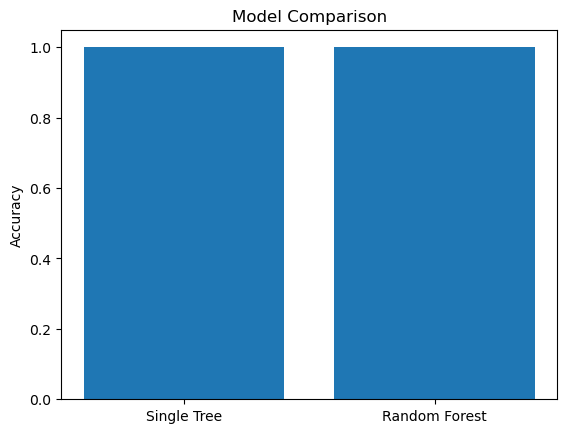

In [84]:
import matplotlib.pyplot as plt

models = ['Single Tree', 'Random Forest']
accuracies = [single_accuracy, forest_accuracy]

plt.bar(models, accuracies)
plt.ylabel('Accuracy')
plt.title('Model Comparison')
plt.show()

# Comparing my Forest with Sklearn's Forest 

In [85]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Preparing the data
X_train=train_data.drop('label',axis=1)
y_train=train_data['label']

# Training the Random Forest
random_forest=RandomForestClassifier(n_estimators=10,max_features=2,random_state=22)
random_forest.fit(X_train,y_train)

# Make Predictions
y_pred=random_forest.predict(X_test)

# Calculate the Accuracy Score 
random_accuracy=accuracy_score(y_test,y_pred)
print('Sklearn Random Forest Accuracy = ',random_accuracy)

Sklearn Random Forest Accuracy =  1.0


Accuracy of all three Models (My custom Random Forest, Sklearn Random Forest and Single Decision Tree Classifier) is the same.

# Visualization

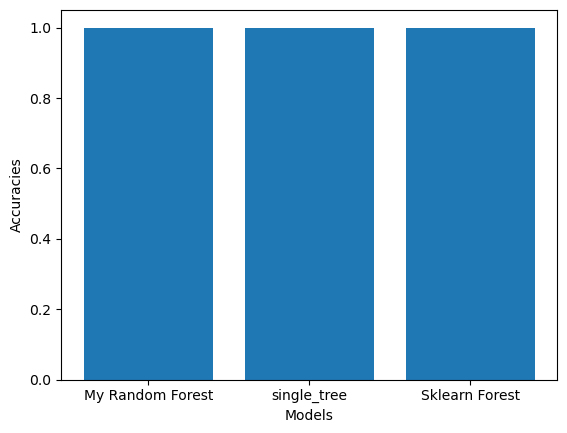

In [88]:
import matplotlib.pyplot as plt

accuracies = [forest_accuracy,single_accuracy,random_accuracy]
models = ['My Random Forest','single_tree','Sklearn Forest']
plt.bar(models,accuracies)
plt.xlabel('Models')
plt.ylabel('Accuracies')
plt.show()